In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

In [7]:
############################
##### Define Functions #####
############################
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [8]:
########################
##### Load Dataset #####
########################

df = pd.read_csv("final_data.csv", index_col=0)
# df.head()
# df.isnull().sum()

In [9]:
#############################################
##### Feature selection and engineering #####
#############################################

X_numeric_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'location_has_non_latin',
'description_has_non_latin', 'requirements_has_non_latin', 'has_requirements',
'has_location', 'has_location_details']
X_text_cols = ['title', 'description_and_requirements']
# location, description, requirements will be dropped.
# ['country_state', 'country'] are dropped for now, will decide once location column is filled in
y_col = ['fraudulent']

df2 = df[X_numeric_cols+X_text_cols+y_col].dropna()

df2["combined_text"] = df2["title"] + " " + df2["description_and_requirements"]
X_text_cols = ["combined_text"]

X = df2[X_numeric_cols+X_text_cols]
y = df2[y_col]

In [14]:
##################################
##### Define hyperparameters #####
##################################

tree_params = {
    'clf__max_depth': [3, 5],
    'clf__criterion': ['entropy'],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2, 3, 5],                   # Added
    'clf__min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],    # Added
    'clf__max_leaf_nodes': [None, 3, 5, 10, 20, 30]          # Added
}

In [15]:
###########################
##### Train the model #####
###########################
fbeta = make_scorer(fbeta_score, beta=2)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit TfidfVectorizer
preprocessor = ColumnTransformer(
    transformers=[
        ("text_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "combined_text"),
        ("num_scaled", MinMaxScaler(), X_numeric_cols)
    ],
    remainder='drop'
)

# Train logistic regression model
model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42))
])


tree_grid = GridSearchCV(
    estimator=model,
    param_grid=tree_params,
    scoring=fbeta,
    cv=5,
    n_jobs=-1,
    verbose=1
)



tree_grid.fit(X_train, y_train)
best_tree_model = tree_grid.best_estimator_
# Make predictions and print classification report
y_pred = best_tree_model.predict(X_test)


Fitting 5 folds for each of 384 candidates, totalling 1920 fits


Best parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__max_leaf_nodes': 20, 'clf__min_impurity_decrease': 0.0, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3410
           1       0.86      0.36      0.51       257

    accuracy                           0.95      3667
   macro avg       0.91      0.68      0.74      3667
weighted avg       0.95      0.95      0.94      3667

F2 Score: 0.4052863436123348


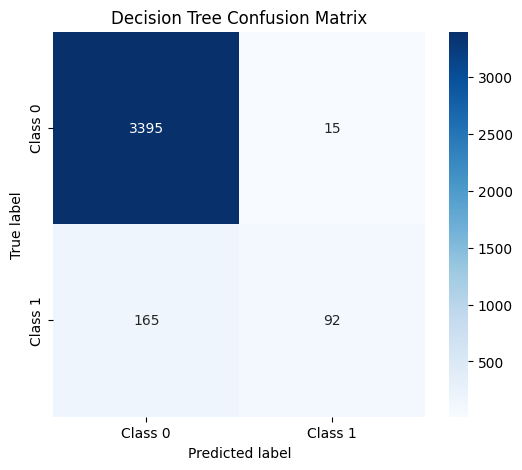

In [21]:
###########################
##### Display results #####
###########################

print("Best parameters:", tree_grid.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("F2 Score:", fbeta_score(y_test, y_pred, beta=2, average='binary'))
plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=[0, 1]), f"Decision Tree Confusion Matrix")

In [20]:
##########################
##### Save the model #####
##########################

import pickle

# Save the model
filename = 'models/decision_tree_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_tree_model, file)